<h1 align="center"> <span style="color:darkslategray">ASHRAE</span><h1><h2 span align="center"><span style="color:darkslategray">A Nagy energia előrejelző versenypályázat III</h2><br/><h3 span align="center"><span style="color:darkslategray">Mennyi energiát fogyaszt egy épület?</span></h3>

### <span style="color:indigo"> Bevezetés </span>

Ebben a versenykiírásban a feladat olyan model fejlesztése, mely képes pontosan előrejelezni egy épület energia fogyasztását a követlező területeken: elektromosság, vízhűtés, gőz , illetve melegvíz. Az adatok több mint 1000 épület három évre visszamenő adatait tartalmazzák. 

A kiírás célja, hogy a energiamegtakarítás jobb becslése révén motiválja a nagybefektetőket és pénzügyi intézményeket a területbe történő befektetésre, ezzel előrelendítve a hatékonyság kiépítését. Általánosságban az épületek energiahatékonyságának javítása illeszkedik napjaink egyik legmeghatározóbb agendájába, a klímaváltozás negatív következményei elleni küzdelemhez. Eszerint a fogyasztás visszafogása csökkentheti a környezeti terhelést, azon belül is különösképp az üvegházhatást okozó gázok kibocsátásának a visszafogását. 

Az energiahatékonyság predikciójában rejlő legjelentősebb kihívás a kontrafaktuális állapot becslése, vagyis jelen esetben annak meghatározása, hogy mennyi energiát fogyasztott volna az adott épület abban az esetben, ha az energiafogyasztással kapcsolatos fejlesztések nem kerültek volna kivitelezésre. A gépi tanulás segítségével olyan model fejlesztése a cél, mely három évet felölelő energetikai mérési és időjárás adatok alapján képes pontos becslést adni az energiahatékonyság javulására vonatkozólag. 

### <span style="color:indigo"> Fájlok:</span>

<b>train.csv</b><br/>
<ul>
<li><i>building_id</i> - Idegen kulcs az épület metadata fájlhoz.</li><br/>
<li><i>meter</i> - A mérő azonosító kódja (0: elektromos áram (electricity), 1: hidegvíz (chilledwater), 2: gőz (steam), 3: melegvíz (hotwater). Nem minden épület rendelkezik minden mérő típussal.</li><br/>
<li><i>timestamp</i> - az időpont, amikor a mérés megvalósult</li><br/>
<li><i>meter_reading</i> - A célváltozó. Az energiafogyasztás kWh-ban kifejezve (vagy azzal ekvivalens). Valós adatok révén figyelembe kell venni a mérési hibát, mely a modellezési hibának az baseline szintjeként értelmezhető.</li>
</ul>


<b>building_meta.csv</b><br/>
<ul>
<li><i>site_id</i> - Helyszín, idegen kulcs az időjárás fájlhoz.</li><br/>
<li><i>building_id</i> - Idegen kulcs a training fájlhoz</li><br/>
<li><i>primary_use</i> - Az épület elsődleges tevékenységének kategóriája  az EnergieStar ingatlan típus besorolása alapján</li><br/>
<li><i>square_feet</i> - Az épület bruttó területe</li><br/>
<li><i>year_built</i> - Az épület megynitásának időpontja</li><br/>
<li><i>floor_count</i> - Az épület emeleteinek a száma</li><br/>
</ul>

<b>weather_[train/test].csv</b><br/>
<ul>
<li><i>site_id</i> - Idegen kulcs az időjárás fájlhoz.</li><br/>
<li><i>air_temperature</i> - Hőmérséklet Celsius fokban</li><br/>
<li><i>cloud_coverage</i> - Az arány, amilyen mértékben felhők borítják az eget</li><br/>
<li><i>dew_temperature</i> - Harmatpont Celsius fokban</li><br/>
<li><i>precip_depth_1_hr</i> - Csapadékmennyiség millimeterben</li><br/>
<li><i>sea_level_pressure</i> - Tengerszintre átszámított légnyomás millibárban</li><br/>
<li><i>wind_direction</i> - Szélirány iránytű szerinti fokban</li><br/>
<li><i>wind_speed</i> - Szélerősség m/s-ban</li><br/>
</ul>

<b>test.csv</b><br/>
<ul>
<li><i>row_id</i> - Idegen kulcs az időjárás fájlhoz</li><br/>
<li><i>building_id</i> - Idegen kulcs a training fájlhoz</li><br/>
<li><i>meter</i> - A mérő azonosító kódja (0: elektromosság (electricity), 1: vízhűtés (chilledwater), 2: gőz (steam), 3: melegvíz (hotwater). Nem minden épület rendelkezik minden mérő típussal.</li><br/>
<li><i>timestamp</i> - az időpont, amikor a mérés megvalósult</li>
</ul>


<b>sample_submission.csv</b>

    Az érvényes minta.

### <span style="color:dimgray"> Csomagok importálása</span>

In [1]:
# Csomagok importálása validációhoz
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics, model_selection

# Csomagok importálása vizualizációhoz
import matplotlib.pyplot as plt
import seaborn as sns

# Csomagok importálása modellezéshez
import xgboost as xgb
#import catboost as cbt
import lightgbm as lgbm

# Általános csomagok importálása
import pandas as pd
import numpy as np
import os
from IPython.display import display_html
from datetime import datetime

### <span style="color:dimgray"> Adatok betöltése </span>

In [2]:
# Az elérési út megadása
root = 'C:/Users/ZsoltNagy/Desktop/github_projects/ASHRAE/project_ASHRAE/Data'

In [3]:
# Adatok betöltése
df_train = pd.read_csv(os.path.join(root, 'train.csv'))
df_test = pd.read_csv(os.path.join(root, 'test.csv'))
df_weather_train = pd.read_csv(os.path.join(root, 'weather_train.csv'))
df_weather_test = pd.read_csv(os.path.join(root, 'weather_test.csv'))
df_building = pd.read_csv(os.path.join(root, 'building_metadata.csv'))

In [4]:
# Gyors pillantás az adatokra
display(df_train.iloc[:10,:])
display(df_test.iloc[:10,:])
display(df_weather_train.iloc[:10,:])
display(df_weather_test.iloc[:10,:])
display(df_building.iloc[:10,:])

building_id  meter            timestamp  meter_reading
0            0      0  2016-01-01 00:00:00            0.0
1            1      0  2016-01-01 00:00:00            0.0
2            2      0  2016-01-01 00:00:00            0.0
3            3      0  2016-01-01 00:00:00            0.0
4            4      0  2016-01-01 00:00:00            0.0
5            5      0  2016-01-01 00:00:00            0.0
6            6      0  2016-01-01 00:00:00            0.0
7            7      0  2016-01-01 00:00:00            0.0
8            8      0  2016-01-01 00:00:00            0.0
9            9      0  2016-01-01 00:00:00            0.0

row_id  building_id  meter            timestamp
0       0            0      0  2017-01-01 00:00:00
1       1            1      0  2017-01-01 00:00:00
2       2            2      0  2017-01-01 00:00:00
3       3            3      0  2017-01-01 00:00:00
4       4            4      0  2017-01-01 00:00:00
5       5            5      0  2017-01-01 00:00:00
6       6            6      0  2017-01-01 00:00:00
7       7            7      0  2017-01-01 00:00:00
8       8            7      1  2017-01-01 00:00:00
9       9            8      0  2017-01-01 00:00:00

site_id            timestamp  air_temperature  cloud_coverage  \
0        0  2016-01-01 00:00:00             25.0             6.0   
1        0  2016-01-01 01:00:00             24.4             NaN   
2        0  2016-01-01 02:00:00             22.8             2.0   
3        0  2016-01-01 03:00:00             21.1             2.0   
4        0  2016-01-01 04:00:00             20.0             2.0   
5        0  2016-01-01 05:00:00             19.4             NaN   
6        0  2016-01-01 06:00:00             21.1             6.0   
7        0  2016-01-01 07:00:00             21.1             NaN   
8        0  2016-01-01 08:00:00             20.6             NaN   
9        0  2016-01-01 09:00:00             21.1             NaN   

   dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  \
0             20.0                NaN              1019.7             0.0   
1             21.1               -1.0              1020.2            70.0   
2             21.1                0.0              1020.2             0.0   
3             20.6                0.0              1020.1             0.0   
4             20.0               -1.0              1020.0           250.0   
5             19.4                0.0                 NaN             0.0   
6             21.1               -1.0              1019.4             0.0   
7             21.1                0.0              1018.8           210.0   
8             20.0                0.0              1018.1             0.0   
9             20.6                0.0              1019.0           290.0   

   wind_speed  
0         0.0  
1         1.5  
2         0.0  
3         0.0  
4         2.6  
5         0.0  
6         0.0  
7         1.5  
8         0.0  
9         1.5

site_id            timestamp  air_temperature  cloud_coverage  \
0        0  2017-01-01 00:00:00             17.8             4.0   
1        0  2017-01-01 01:00:00             17.8             2.0   
2        0  2017-01-01 02:00:00             16.1             0.0   
3        0  2017-01-01 03:00:00             17.2             0.0   
4        0  2017-01-01 04:00:00             16.7             2.0   
5        0  2017-01-01 05:00:00             15.6             2.0   
6        0  2017-01-01 06:00:00             15.0             0.0   
7        0  2017-01-01 07:00:00             15.0             2.0   
8        0  2017-01-01 08:00:00             13.3             0.0   
9        0  2017-01-01 09:00:00             12.2             4.0   

   dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  \
0             11.7                NaN              1021.4           100.0   
1             12.8                0.0              1022.0           130.0   
2             12.8                0.0              1021.9           140.0   
3             13.3                0.0              1022.2           140.0   
4             13.3                0.0              1022.3           130.0   
5             12.8                0.0              1022.1           130.0   
6             12.8                0.0              1021.7           150.0   
7             13.3                0.0              1021.6             0.0   
8             12.2                0.0              1021.4             0.0   
9             11.7                0.0              1021.4             0.0   

   wind_speed  
0         3.6  
1         3.1  
2         3.1  
3         3.1  
4         2.6  
5         2.1  
6         1.5  
7         0.0  
8         0.0  
9         0.0

site_id  building_id          primary_use  square_feet  year_built  \
0        0            0            Education         7432      2008.0   
1        0            1            Education         2720      2004.0   
2        0            2            Education         5376      1991.0   
3        0            3            Education        23685      2002.0   
4        0            4            Education       116607      1975.0   
5        0            5            Education         8000      2000.0   
6        0            6  Lodging/residential        27926      1981.0   
7        0            7            Education       121074      1989.0   
8        0            8            Education        60809      2003.0   
9        0            9               Office        27000      2010.0   

   floor_count  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  
5          NaN  
6          NaN  
7          NaN  
8          NaN  
9          NaN

In [5]:
# Alapinformációk lekérése az adatszetekről
df_train.info()
print('')
df_test.info()
print('')
df_weather_train.info()
print('')
df_weather_test.info()
print('')
df_building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
building_id      int64
meter            int64
timestamp        object
meter_reading    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 616.9+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41697600 entries, 0 to 41697599
Data columns (total 4 columns):
row_id         int64
building_id    int64
meter          int64
timestamp      object
dtypes: int64(3), object(1)
memory usage: 1.2+ GB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null int64
timestamp             139773 non-null object
air_temperature       139718 non-null float64
cloud_coverage        70600 non-null float64
dew_temperature       139660 non-null float64
precip_depth_1_hr     89484 non-null float64
sea_level_pressure    129155 non-null float64
wind_direction        133505 non-null float64
win

### <span style="color:dimgray"> Memóriahasználat csökkentése </span>

#### A train és test adatszetek memóriahasználata jelentős, mely hatékonyan csökkenthető a változók konvertálásával

In [6]:
## Függvény a memóriahasználat csökkentéséhez. Forrás: https://www.kaggle.com/caesarlupum/ashrae-start-here-a-gentle-introduction
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [7]:
# A memóriahasználatot csökkentő függvény alkalmazása

df_train_red = reduce_mem_usage(df_train)
df_test_red = reduce_mem_usage(df_test)
df_weather_train_red = reduce_mem_usage(df_weather_train)
df_weather_test_red = reduce_mem_usage(df_weather_test)
df_building_red = reduce_mem_usage(df_building)


Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)


In [8]:
# Alapstatisztikák lekérése az adatok transzformáció előtti és utáni összehasonlításához:

# df_train
desc_dftrain = df_train.describe()
desc_dftrain_red = df_train_red.describe()

desc_dftrain_styler = desc_dftrain.style.set_table_attributes("style='display:inline'").set_caption('Eredeti df_train')
desc_dftrain_red_styler = desc_dftrain_red.style.set_table_attributes("style='display:inline'").set_caption('Transzformált df_train')

display_html(desc_dftrain_styler._repr_html_()+desc_dftrain_red_styler._repr_html_(), raw=True)

# df_test
desc_dftest = df_test.describe()
desc_dftest_red = df_test_red.describe()

desc_dftest_styler = desc_dftest.style.set_table_attributes("style='display:inline'").set_caption('Eredeti df_test')
desc_dftest_red_styler = desc_dftest_red.style.set_table_attributes("style='display:inline'").set_caption('Transzformált df_test')

display_html(desc_dftest_styler._repr_html_()+desc_dftest_red_styler._repr_html_(), raw=True)

# df_weather_train
desc_dfweather_train = df_weather_train.describe()
desc_dfweather_train_red = df_weather_train_red.describe()

desc_dfweather_train_styler = desc_dfweather_train.style.set_table_attributes("style='display:inline'").set_caption('Eredeti df_weather_train')
desc_dfweather_train_red_styler = desc_dfweather_train_red.style.set_table_attributes("style='display:inline'").set_caption('Transzformált df_weather_train')

display_html(desc_dfweather_train_styler._repr_html_()+desc_dfweather_train_red_styler._repr_html_(), raw=True)

# df_weather_test
desc_dfweather_test = df_weather_test.describe()
desc_dfweather_test_red = df_weather_test_red.describe()

desc_dfweather_test_styler = desc_dfweather_test.style.set_table_attributes("style='display:inline'").set_caption('Eredeti df_weather_test')
desc_dfweather_test_red_styler = desc_dfweather_test_red.style.set_table_attributes("style='display:inline'").set_caption('Transzformált df_weather_test')

display_html(desc_dfweather_test_styler._repr_html_()+desc_dfweather_test_red_styler._repr_html_(), raw=True)

# building
desc_dfbuilding = df_building.describe()
desc_dfbuilding_red = df_building_red.describe()

desc_dfbuilding_styler = desc_dfbuilding.style.set_table_attributes("style='display:inline'").set_caption('Eredeti df_building')
desc_dfbuilding_red_styler = desc_dfbuilding_red.style.set_table_attributes("style='display:inline'").set_caption('Transzformált df_building')

display_html(desc_dfbuilding_styler._repr_html_()+desc_dfbuilding_red_styler._repr_html_(), raw=True)


Eredeti df_train 
 
 
 building_id 
 meter 
 meter_reading 
 
 
 count 
 2.02161e+07 
 2.02161e+07 
 2.02161e+07 
 
 mean 
 799.278 
 0.662441 
 1988.71 
 
 std 
 426.913 
 0.930992 
 153216 
 
 min 
 0 
 0 
 0 
 
 25% 
 393 
 0 
 18.3 
 
 50% 
 895 
 0 
 78.775 
 
 75% 
 1179 
 1 
 267.984 
 
 max 
 1448 
 3 
 2.19047e+07 
 
 
 Transzformált df_train 
 
 
 building_id 
 meter 
 meter_reading 
 
 
 count 
 2.02161e+07 
 2.02161e+07 
 2.02161e+07 
 
 mean 
 799.278 
 0.662441 
 1988.71 
 
 std 
 426.913 
 0.930992 
 153216 
 
 min 
 0 
 0 
 0 
 
 25% 
 393 
 0 
 18.3 
 
 50% 
 895 
 0 
 78.775 
 
 75% 
 1179 
 1 
 267.984 
 
 max 
 1448 
 3 
 2.19047e+07

Eredeti df_test 
 
 
 row_id 
 building_id 
 meter 
 
 
 count 
 4.16976e+07 
 4.16976e+07 
 4.16976e+07 
 
 mean 
 2.08488e+07 
 807.582 
 0.664286 
 
 std 
 1.20371e+07 
 429.768 
 0.927807 
 
 min 
 0 
 0 
 0 
 
 25% 
 1.04244e+07 
 404.75 
 0 
 
 50% 
 2.08488e+07 
 900 
 0 
 
 75% 
 3.12732e+07 
 1194.25 
 1 
 
 max 
 4.16976e+07 
 1448 
 3 
 
 
 Transzformált df_test 
 
 
 row_id 
 building_id 
 meter 
 
 
 count 
 4.16976e+07 
 4.16976e+07 
 4.16976e+07 
 
 mean 
 2.08488e+07 
 807.582 
 0.664286 
 
 std 
 1.20371e+07 
 429.768 
 0.927807 
 
 min 
 0 
 0 
 0 
 
 25% 
 1.04244e+07 
 404.75 
 0 
 
 50% 
 2.08488e+07 
 900 
 0 
 
 75% 
 3.12732e+07 
 1194.25 
 1 
 
 max 
 4.16976e+07 
 1448 
 3

Eredeti df_weather_train 
 
 
 site_id 
 air_temperature 
 cloud_coverage 
 dew_temperature 
 precip_depth_1_hr 
 sea_level_pressure 
 wind_direction 
 wind_speed 
 
 
 count 
 139773 
 139718 
 70600 
 139660 
 89484 
 129155 
 133505 
 139469 
 
 mean 
 7.47898 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 
 std 
 4.60474 
 0 
 0 
 0 
 nan 
 nan 
 nan 
 0 
 
 min 
 0 
 -28.9062 
 0 
 -35 
 -1 
 968 
 0 
 0 
 
 25% 
 3 
 7.19922 
 0 
 0.600098 
 0 
 1012 
 80 
 2.09961 
 
 50% 
 7 
 15 
 2 
 8.29688 
 0 
 1016.5 
 190 
 3.09961 
 
 75% 
 11 
 22.2031 
 4 
 14.3984 
 0 
 1021 
 280 
 5 
 
 max 
 15 
 47.1875 
 9 
 26.0938 
 343 
 1046 
 360 
 19 
 
 
 Transzformált df_weather_train 
 
 
 site_id 
 air_temperature 
 cloud_coverage 
 dew_temperature 
 precip_depth_1_hr 
 sea_level_pressure 
 wind_direction 
 wind_speed 
 
 
 count 
 139773 
 139718 
 70600 
 139660 
 89484 
 129155 
 133505 
 139469 
 
 mean 
 7.47898 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 
 std 
 4.60474 
 0 
 0 
 0 
 nan 
 nan 
 nan 
 0 
 
 min 
 0 
 -28.9062 
 0 
 -35 
 -1 
 968 
 0 
 0 
 
 25% 
 3 
 7.19922 
 0 
 0.600098 
 0 
 1012 
 80 
 2.09961 
 
 50% 
 7 
 15 
 2 
 8.29688 
 0 
 1016.5 
 190 
 3.09961 
 
 75% 
 11 
 22.2031 
 4 
 14.3984 
 0 
 1021 
 280 
 5 
 
 max 
 15 
 47.1875 
 9 
 26.0938 
 343 
 1046 
 360 
 19

Eredeti df_weather_test 
 
 
 site_id 
 air_temperature 
 cloud_coverage 
 dew_temperature 
 precip_depth_1_hr 
 sea_level_pressure 
 wind_direction 
 wind_speed 
 
 
 count 
 277243 
 277139 
 136795 
 276916 
 181655 
 255978 
 264873 
 276783 
 
 mean 
 7.48465 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 
 std 
 4.61696 
 0 
 0 
 0 
 nan 
 nan 
 nan 
 0 
 
 min 
 0 
 -28.0938 
 0 
 -31.5938 
 -1 
 972 
 0 
 0 
 
 25% 
 3 
 7.19922 
 0 
 0.600098 
 0 
 1011.5 
 80 
 2.09961 
 
 50% 
 7 
 15 
 2 
 8.39844 
 0 
 1016.5 
 190 
 3.09961 
 
 75% 
 12 
 22.2031 
 4 
 15 
 0 
 1021 
 280 
 4.60156 
 
 max 
 15 
 48.3125 
 9 
 26.7031 
 597 
 1050 
 360 
 24.2031 
 
 
 Transzformált df_weather_test 
 
 
 site_id 
 air_temperature 
 cloud_coverage 
 dew_temperature 
 precip_depth_1_hr 
 sea_level_pressure 
 wind_direction 
 wind_speed 
 
 
 count 
 277243 
 277139 
 136795 
 276916 
 181655 
 255978 
 264873 
 276783 
 
 mean 
 7.48465 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 
 std 
 4.61696 
 0 
 0 
 0 
 nan 
 nan 
 nan 
 0 
 
 min 
 0 
 -28.0938 
 0 
 -31.5938 
 -1 
 972 
 0 
 0 
 
 25% 
 3 
 7.19922 
 0 
 0.600098 
 0 
 1011.5 
 80 
 2.09961 
 
 50% 
 7 
 15 
 2 
 8.39844 
 0 
 1016.5 
 190 
 3.09961 
 
 75% 
 12 
 22.2031 
 4 
 15 
 0 
 1021 
 280 
 4.60156 
 
 max 
 15 
 48.3125 
 9 
 26.7031 
 597 
 1050 
 360 
 24.2031

Eredeti df_building 
 
 
 site_id 
 building_id 
 square_feet 
 year_built 
 floor_count 
 
 
 count 
 1449 
 1449 
 1449 
 675 
 355 
 
 mean 
 6.95238 
 724 
 92111.8 
 inf 
 3.74023 
 
 std 
 5.00343 
 418.435 
 110770 
 31.0625 
 3.33398 
 
 min 
 0 
 0 
 283 
 1900 
 1 
 
 25% 
 3 
 362 
 23012 
 1949 
 1 
 
 50% 
 5 
 724 
 57673 
 1970 
 3 
 
 75% 
 13 
 1086 
 115676 
 1995 
 5 
 
 max 
 15 
 1448 
 875000 
 2017 
 26 
 
 
 Transzformált df_building 
 
 
 site_id 
 building_id 
 square_feet 
 year_built 
 floor_count 
 
 
 count 
 1449 
 1449 
 1449 
 675 
 355 
 
 mean 
 6.95238 
 724 
 92111.8 
 inf 
 3.74023 
 
 std 
 5.00343 
 418.435 
 110770 
 31.0625 
 3.33398 
 
 min 
 0 
 0 
 283 
 1900 
 1 
 
 25% 
 3 
 362 
 23012 
 1949 
 1 
 
 50% 
 5 
 724 
 57673 
 1970 
 3 
 
 75% 
 13 
 1086 
 115676 
 1995 
 5 
 
 max 
 15 
 1448 
 875000 
 2017 
 26

### <span style="color:dimgray"> Adatszetek egyesítése </span>

In [9]:
train = df_train_red.merge(df_building_red, on='building_id', how='left')
test = df_test_red.merge(df_building_red, on='building_id', how='left')

train = train.merge(df_weather_train_red, on=['site_id', 'timestamp'], how='left')
test = test.merge(df_weather_test_red, on=['site_id', 'timestamp'], how='left')

display(train.iloc[:10,:])
display(test.iloc[:10,:])

building_id  meter            timestamp  meter_reading  site_id  \
0            0      0  2016-01-01 00:00:00            0.0        0   
1            1      0  2016-01-01 00:00:00            0.0        0   
2            2      0  2016-01-01 00:00:00            0.0        0   
3            3      0  2016-01-01 00:00:00            0.0        0   
4            4      0  2016-01-01 00:00:00            0.0        0   
5            5      0  2016-01-01 00:00:00            0.0        0   
6            6      0  2016-01-01 00:00:00            0.0        0   
7            7      0  2016-01-01 00:00:00            0.0        0   
8            8      0  2016-01-01 00:00:00            0.0        0   
9            9      0  2016-01-01 00:00:00            0.0        0   

           primary_use  square_feet  year_built  floor_count  air_temperature  \
0            Education         7432      2008.0          NaN             25.0   
1            Education         2720      2004.0          NaN             25.0   
2            Education         5376      1991.0          NaN             25.0   
3            Education        23685      2002.0          NaN             25.0   
4            Education       116607      1975.0          NaN             25.0   
5            Education         8000      2000.0          NaN             25.0   
6  Lodging/residential        27926      1981.0          NaN             25.0   
7            Education       121074      1989.0          NaN             25.0   
8            Education        60809      2003.0          NaN             25.0   
9               Office        27000      2010.0          NaN             25.0   

   cloud_coverage  dew_temperature  precip_depth_1_hr  sea_level_pressure  \
0             6.0             20.0                NaN              1019.5   
1             6.0             20.0                NaN              1019.5   
2             6.0             20.0                NaN              1019.5   
3             6.0             20.0                NaN              1019.5   
4             6.0             20.0                NaN              1019.5   
5             6.0             20.0                NaN              1019.5   
6             6.0             20.0                NaN              1019.5   
7             6.0             20.0                NaN              1019.5   
8             6.0             20.0                NaN              1019.5   
9             6.0             20.0                NaN              1019.5   

   wind_direction  wind_speed  
0             0.0         0.0  
1             0.0         0.0  
2             0.0         0.0  
3             0.0         0.0  
4             0.0         0.0  
5             0.0         0.0  
6             0.0         0.0  
7             0.0         0.0  
8             0.0         0.0  
9             0.0         0.0

row_id  building_id  meter            timestamp  site_id  \
0       0            0      0  2017-01-01 00:00:00        0   
1       1            1      0  2017-01-01 00:00:00        0   
2       2            2      0  2017-01-01 00:00:00        0   
3       3            3      0  2017-01-01 00:00:00        0   
4       4            4      0  2017-01-01 00:00:00        0   
5       5            5      0  2017-01-01 00:00:00        0   
6       6            6      0  2017-01-01 00:00:00        0   
7       7            7      0  2017-01-01 00:00:00        0   
8       8            7      1  2017-01-01 00:00:00        0   
9       9            8      0  2017-01-01 00:00:00        0   

           primary_use  square_feet  year_built  floor_count  air_temperature  \
0            Education         7432      2008.0          NaN        17.796875   
1            Education         2720      2004.0          NaN        17.796875   
2            Education         5376      1991.0          NaN        17.796875   
3            Education        23685      2002.0          NaN        17.796875   
4            Education       116607      1975.0          NaN        17.796875   
5            Education         8000      2000.0          NaN        17.796875   
6  Lodging/residential        27926      1981.0          NaN        17.796875   
7            Education       121074      1989.0          NaN        17.796875   
8            Education       121074      1989.0          NaN        17.796875   
9            Education        60809      2003.0          NaN        17.796875   

   cloud_coverage  dew_temperature  precip_depth_1_hr  sea_level_pressure  \
0             4.0        11.703125                NaN              1021.5   
1             4.0        11.703125                NaN              1021.5   
2             4.0        11.703125                NaN              1021.5   
3             4.0        11.703125                NaN              1021.5   
4             4.0        11.703125                NaN              1021.5   
5             4.0        11.703125                NaN              1021.5   
6             4.0        11.703125                NaN              1021.5   
7             4.0        11.703125                NaN              1021.5   
8             4.0        11.703125                NaN              1021.5   
9             4.0        11.703125                NaN              1021.5   

   wind_direction  wind_speed  
0           100.0    3.599609  
1           100.0    3.599609  
2           100.0    3.599609  
3           100.0    3.599609  
4           100.0    3.599609  
5           100.0    3.599609  
6           100.0    3.599609  
7           100.0    3.599609  
8           100.0    3.599609  
9           100.0    3.599609

### <span style="color:dimgray"> Adatok feltérképezése </span>

#### Az adatok feltérképezése egy iteratív, végnélküli folyamat, mely során igyekszünk megérteni az adatban rejlő mintázatokat, összefüggéseket, trendeket, valamint anomáliákat alapvető statisztikai eljárások használata révén. A lentebbi elemzés betekintést nyújt a folyamatba, azonban korántsem tekinthető minden részletre kiterjedő vizsgálatnak, helyet hagyva az olvasó számára a további elemzésekre. 

#### <span style="color:darkmagenta">Hiányzó adatok vizsgálata</span>

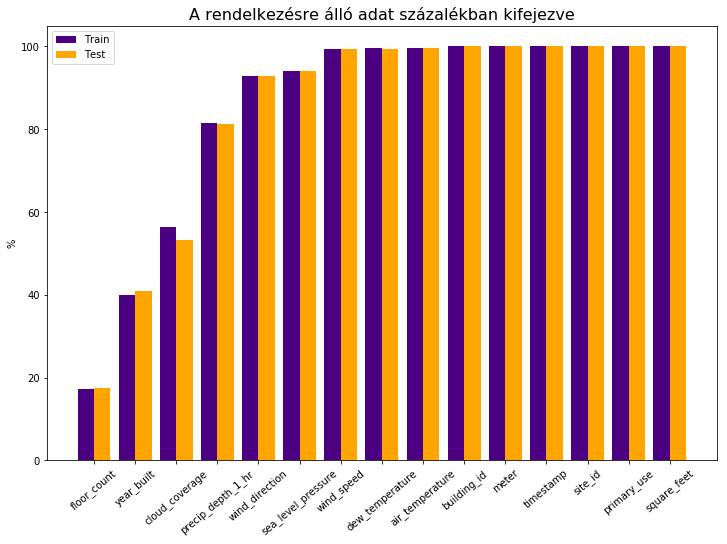

In [10]:
train_missing = train.drop('meter_reading', axis=1).count().divide(len(train)).round(4).sort_values()*100
test_missing = test.drop('row_id', axis=1).count().divide(len(test)).round(4).sort_values()*100


fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(train.drop('meter_reading', axis=1).columns))
bar_width = 0.4
b1 = ax.bar(x, train_missing, width=bar_width, color='indigo')
b2 = ax.bar(x + bar_width, test_missing, width=bar_width, color='orange')

# Fix the x-axes.
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(train_missing.index, rotation=40)
ax.legend([b1, b2], ['Train', 'Test'])
ax.set_ylabel('%')
ax.set_title('A rendelkezésre álló adat százalékban kifejezve', fontsize=16);

#### A fenti ábra alapján látható, hogy három változó, a szintek száma, az építése éve, illetve a felhőtakaró nagysága esetében a rendelkezésre álló adatok mennyisége alacsony. Érdemes tehát utána nézni, hogy esetleg van-e bármilyen mintázat, ami az adathiányt magyarázhatná.

In [42]:
temp_df = train[train['floor_count'].isnull()]
print('Leggyakoribb kategóriák/értékek változónként azon adatpontok esetében, ahol hiányzik az épület szintje változó értéke:')
for columns in temp_df.columns:
    print('')
    print(str(columns) + str(':'))
    print(temp_df[columns].value_counts().head(5))

Leggyakoribb kategóriák/értékek változónként azon adatpontok esetében, ahol hiányzik az épület szintje változó értéke:

building_id:
1298    35136
1249    35136
1301    35128
1241    35116
1296    35115
Name: building_id, dtype: int64

meter:
0    9096083
1    3972549
2    2604116
3    1036419
Name: meter, dtype: int64

timestamp:
2016-12-27 19:00:00    1960
2016-12-27 22:00:00    1960
2016-12-27 20:00:00    1960
2016-12-27 17:00:00    1960
2016-12-18 20:00:00    1959
Name: timestamp, dtype: int64

meter_reading:
0.000000     1620375
2.930700       23181
8.792100       21787
36.599998      21447
5.861400       21309
Name: meter_reading, dtype: int64

site_id:
13    2711763
9     2679323
2     2530312
14    2501506
3     2370097
Name: site_id, dtype: int64

primary_use:
Education                        6254313
Office                           4038322
Lodging/residential              1993811
Entertainment/public assembly    1796262
Public services                  1305198
Name: primary_u

In [41]:
temp_df = train[train['year_built'].isnull()]
print('Leggyakoribb kategóriák/értékek változónként azon adatpontok esetében, ahol hiányzik az épület építésének éve változó értéke:')
for columns in temp_df.columns:
    print('')
    print(str(columns) + str(':'))
    print(temp_df[columns].value_counts().head(5))

Leggyakoribb kategóriák/értékek változónként azon adatpontok esetében, ahol hiányzik az épület építésének éve változó értéke:

building_id:
1249    35136
1298    35136
1301    35128
1241    35116
1297    35115
Name: building_id, dtype: int64

meter:
0    6470035
1    2819559
2    2141016
3     697035
Name: meter, dtype: int64

timestamp:
2016-11-04 07:00:00    1400
2016-11-08 20:00:00    1400
2016-11-08 17:00:00    1399
2016-09-30 15:00:00    1399
2016-10-07 12:00:00    1399
Name: timestamp, dtype: int64

meter_reading:
0.000000     1093734
36.599998      21282
24.400000      20438
61.000000      19960
20.000000      19878
Name: meter_reading, dtype: int64

site_id:
13    2711763
9     2679323
14    2501506
3     1236835
6      668133
Name: site_id, dtype: int64

primary_use:
Education                        4114086
Office                           3318685
Entertainment/public assembly    1423388
Public services                  1161377
Lodging/residential              1078064
Name: pr

In [40]:
temp_df = train[train['cloud_coverage'].isnull()]
print('Leggyakoribb kategóriák/értékek változónként azon adatpontok esetében, ahol hiányzik a felhőtakaró mértéke változó értéke:')
for columns in temp_df.columns:
    print('')
    print(str(columns) + str(':'))
    print(temp_df[columns].value_counts().head(5))

Leggyakoribb kategóriák/értékek változónként azon adatpontok esetében, ahol hiányzik a felhőtakaró mértéke változó értéke:

building_id:
1032    26346
802     26343
801     26343
800     26343
793     26343
Name: building_id, dtype: int64

meter:
0    5329652
1    1742296
2    1247671
3     505746
Name: meter, dtype: int64

timestamp:
2016-11-23 11:00:00    2363
2016-11-23 00:00:00    2359
2016-09-29 08:00:00    2359
2016-11-23 01:00:00    2358
2016-04-07 15:00:00    2343
Name: timestamp, dtype: int64

meter_reading:
0.0      849623
100.0     11682
10.0      11617
20.0      10829
30.0       9576
Name: meter_reading, dtype: int64

site_id:
13    1327342
9     1055963
3      983668
14     944603
15     940006
Name: site_id, dtype: int64

primary_use:
Education                        3682525
Office                           1905997
Entertainment/public assembly     949881
Lodging/residential               910389
Public services                   715976
Name: primary_use, dtype: int64

squ

#### A kapott eredmények alapján érdemes lesz külön figyelmet fordítani a 13-as telekre, valamint az 1249-es és 1298-as azaonosítóval rendelkező épületekre, mivel esetükben adathiány több változó esetében is fennáll.

#### <span style="color:darkmagenta">Egyváltozós elemzés</span>

#### A célváltozó eloszlása erősen ferde a kiugró értékek miatt.

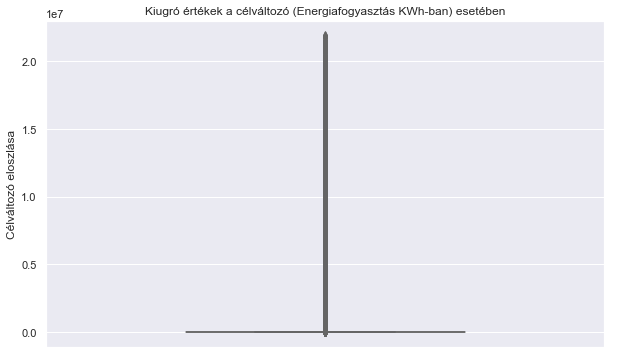

In [37]:
ax = sns.boxplot(y='meter_reading',
                 data=train, 
                 width=0.5,
                 palette="BuPu")
ax.set(ylabel = 'Célváltozó eloszlása')
ax.set_title('Kiugró értékek a célváltozó (Energiafogyasztás KWh-ban) esetében', fontsize=12);

In [15]:
# Kiugró értékek vizsgálata az Interkvartilis terjedelem (IQR) érték alapján

def outliers_iqr(x, mplyr):
    quartile_1, quartile_3 = np.percentile(x, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * mplyr)
    upper_bound = quartile_3 + (iqr * mplyr)
    return list(np.where((x > upper_bound) | (x < lower_bound)))

indexes_outlier = outliers_iqr(train['meter_reading'], 1.5)[0]
train_outliers = train[train.index.isin(indexes_outlier)]
train_no_outliers = train.drop(train.index[indexes_outlier])
print('Kiugró értékek száma a célváltozóban: ' + str(len(train_outliers)))

Kiugró értékek száma a célváltozóban: 2473655


C:\Users\ZsoltNagy\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


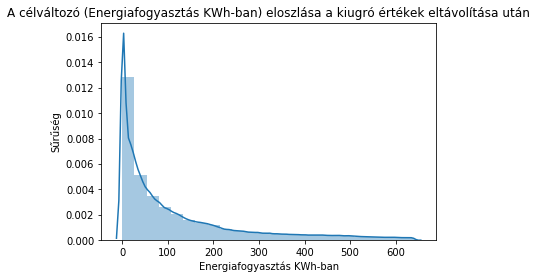

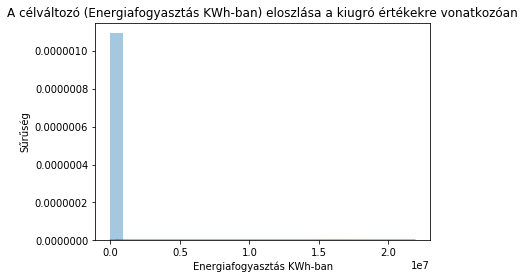

In [16]:
bins1 = np.linspace(min(train_no_outliers['meter_reading']), max(train_no_outliers['meter_reading']), 25)
sns.distplot(train_no_outliers['meter_reading'], bins=bins1)
plt.figsize = [6,6]

plt.title('A célváltozó (Energiafogyasztás KWh-ban) eloszlása a kiugró értékek eltávolítása után')
plt.ylabel('Sűrűség')
plt.xlabel('Energiafogyasztás KWh-ban')
plt.show()

bins2 = np.linspace(min(train_outliers['meter_reading']), max(train_outliers['meter_reading']), 25)
sns.distplot(train_outliers['meter_reading'], bins=bins2)
plt.figsize = [6,6]

plt.title('A célváltozó (Energiafogyasztás KWh-ban) eloszlása a kiugró értékek esetében')
plt.ylabel('Sűrűség')
plt.xlabel('Energiafogyasztás KWh-ban')
plt.show()

C:\Users\ZsoltNagy\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


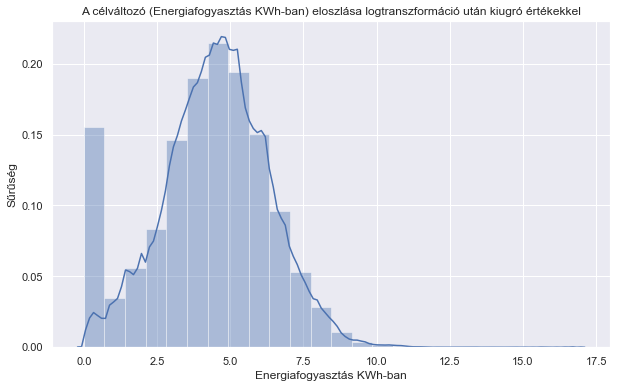

In [83]:
# A célváltozó eloszlásának lekérése logaritmikus transzformációt követően
bins = np.linspace(min(np.log1p(train["meter_reading"].values)), max(np.log1p(train["meter_reading"].values)), 25)
sns.distplot(np.log1p(train['meter_reading']), bins=bins)
plt.figsize = [6,6]
plt.title('A célváltozó (Energiafogyasztás KWh-ban) eloszlása logtranszformáció után kiugró értékekkel')
plt.ylabel('Sűrűség')
plt.xlabel('Energiafogyasztás KWh-ban')
plt.show()

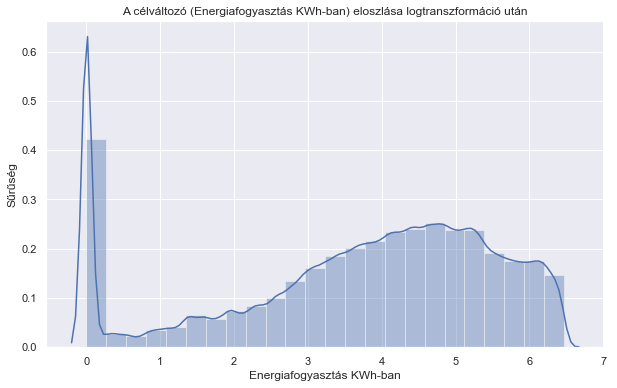

In [84]:
# A célváltozó eloszlásának lekérése logaritmikus transzformációt követően
bins = np.linspace(min(np.log1p(train_no_outliers["meter_reading"].values)), max(np.log1p(train_no_outliers["meter_reading"].values)), 25)
sns.distplot(np.log1p(train_no_outliers['meter_reading']), bins=bins)
plt.figsize = [6,6]
plt.title('A célváltozó (Energiafogyasztás KWh-ban) eloszlása logtranszformáció után')
plt.ylabel('Sűrűség')
plt.xlabel('Energiafogyasztás KWh-ban')
plt.show()

#### A változó eloszlása a logtranszformáció és a kiugró értékek kizárása után is erősen asszimmetrikus 

#### A független változók elemzése

In [85]:
cat_features_df = train[['meter', 'site_id', 'primary_use', 'floor_count']]
num_features_df = train[['square_feet', 'year_built', 'air_temperature', 'cloud_coverage', 'dew_temperature',
                                    'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']]

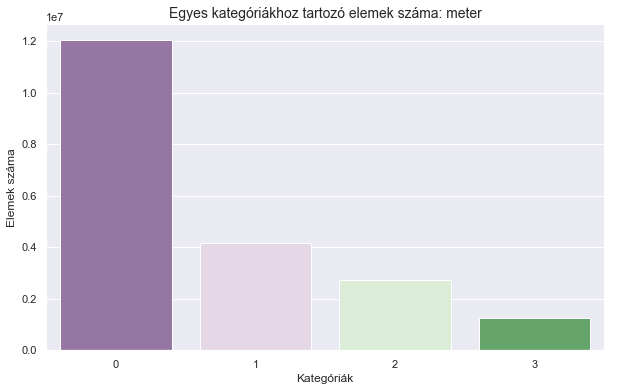

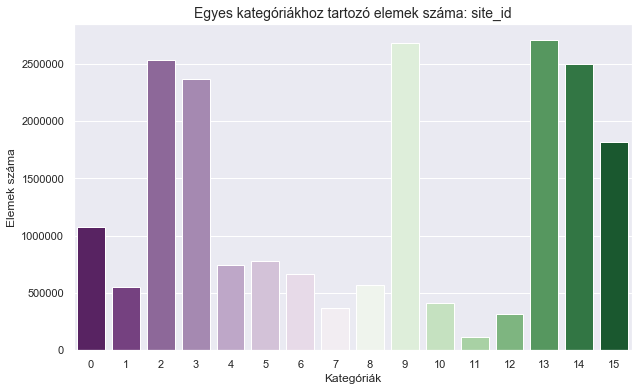

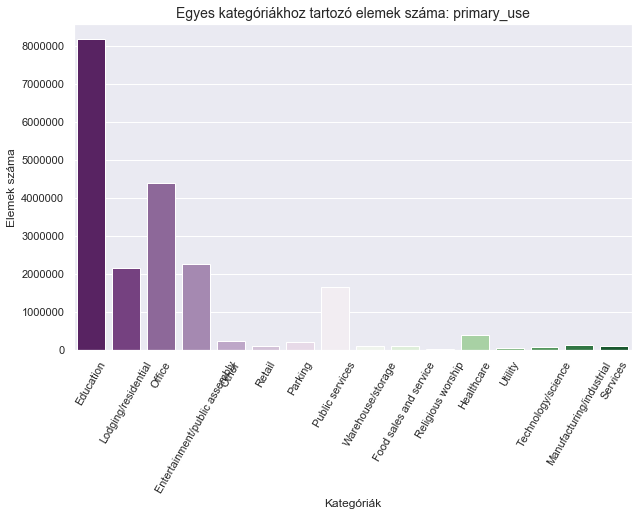

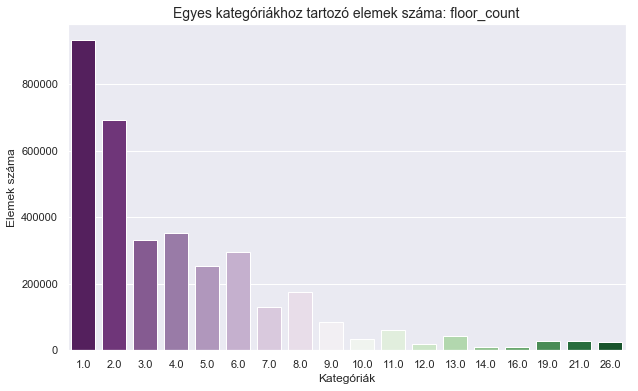

In [86]:
for features in cat_features_df:
    ax = sns.countplot(x=features, data=cat_features_df, palette=("PRGn"))
    ax.set_title(str(str('Egyes kategóriákhoz tartozó elemek száma') + str(': ') + str(features)), fontsize=14)
    ax.set_ylabel('Elemek száma')
    ax.set_xlabel('Kategóriák')
    if features == 'primary_use':
        ax.tick_params(axis='x', rotation=60)
    plt.show()

#### Főbb megállapítások:
<ul>
<li><i>Mérő típus</i> - Legtöbb adat elekromos áram fogyasztással kapcsolatosan, míg legkevesebb a melegvíz mérőhöz áll rendelkezésre </li><br/>
</ul>
<ul>
<li><i>Helyszín </i> - Legtöbb adat a 13-as, a 9-es és a 2-es telkeken lévő épületekkel kapcsolatosan található az adatszetben, míg a legkevesebb a 11 és 12-es telekhez tartozó épületekről áll rendelkezésre </li><br/>
</ul>
<ul>
<li><i>Épület típus </i> - A legtöbb esetben az épület besorolása oktatási kategóriába esett, míg a második leggyakoribb az iroda besorolosú volt </li><br/>
</ul>
<ul>
<li><i>Szintek száma </i> - Az épületek többsége egy vagy kétszintes volt  </li><br/>
</ul>

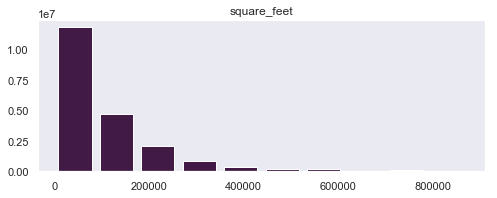

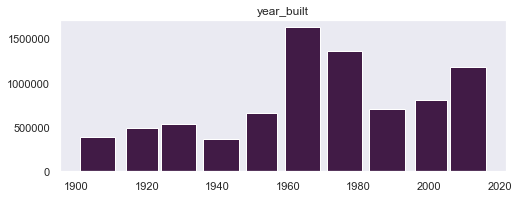

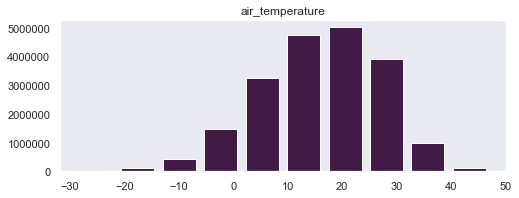

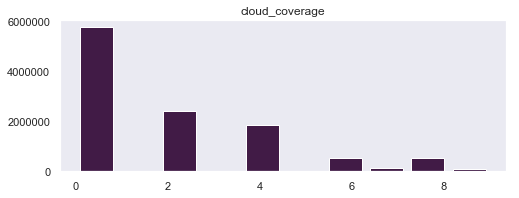

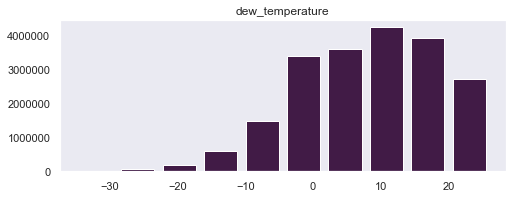

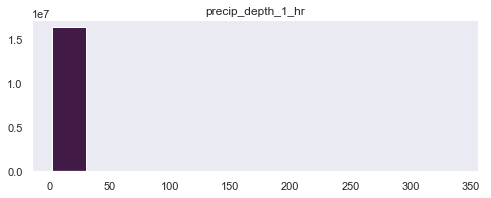

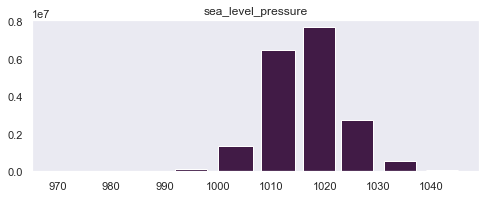

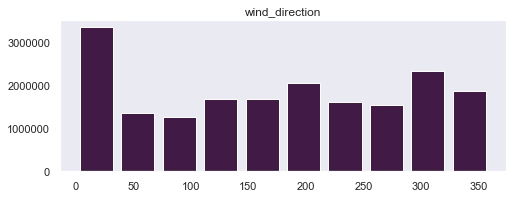

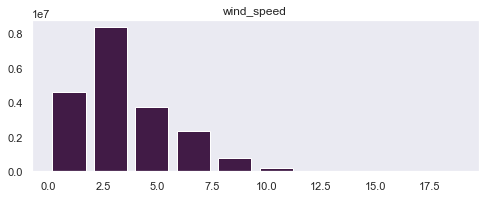

In [88]:
for features in num_features_df:
    num_features_df.hist(column=features, grid=False, figsize=(8,10), layout=(3,1), sharex=True, color='#411B46', rwidth=0.8)
    

#### Főbb megállapítások:
<ul>
<li><i>Alapterület</i> - Számos épület alapterülete meghaladja 200000 négyzetlábat </li><br/>
</ul>
<ul>
<li><i>Építési idő </i> - Az épületek jelentős része az 1960-80-as évek közötti időszakban épült, valószínűsíthatően alacsonyabb energetikai hatékonyság mellett </li><br/>
</ul>
<ul>
<li><i>léghőmérséklet </i> - A levegőhőmérséklet eloszlása közel normális, ami egyrészt köszönhető az egy évet felölelő mérési időszaknak, illetve a helyszínek geográfiai szétszórtságának </li><br/>
</ul>

#### <span style="color:darkmagenta">A változók többváltozós elemzése</span>

#### Adott mérőtípushoz tartozó mérések száma

Text(0.5, 1.0, 'Adott mérőtípushoz tartozó mérések száma')

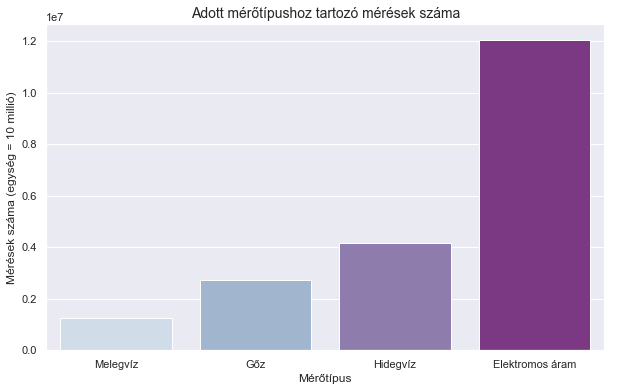

In [89]:
target_count = train['meter'].value_counts()
target_count.index = ['Elektromos áram', 'Hidegvíz', 'Gőz', 'Melegvíz']
target_count = target_count.sort_values().to_frame().reset_index()

ax = sns.barplot(y= "meter", x = "index", data = target_count, palette=("BuPu"))
sns.set(rc={'figure.figsize':(10,6)})
ax.set(xlabel='Mérőtípus', ylabel='Mérések száma (egység = 10 millió)')
ax.set_title('Adott mérőtípushoz tartozó mérések száma', fontsize=14)

#### Összes energiafogyasztás mérőtípusonként

index  meter_reading
0         Melegvíz   4.877499e+08
1  Elektromos áram   2.060313e+09
2         Hidegvíz   2.649007e+09
3              Gőz   3.760286e+10

Text(0.5, 1.0, 'Adott mérőtípushoz tartozó összfogyasztás')

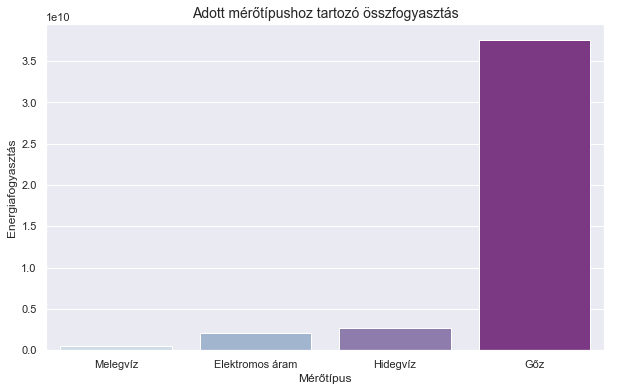

In [92]:
target_sum = train.groupby(['meter'])['meter_reading'].sum()
target_sum.index = ['Elektromos áram', 'Hidegvíz', 'Gőz', 'Melegvíz']
target_sum = target_sum.sort_values().to_frame().reset_index()

ax = sns.barplot(x="index", y = "meter_reading", data = target_sum, palette=("BuPu"))
sns.set(rc={'figure.figsize':(10,6)})
ax.set(xlabel='Mérőtípus', ylabel='Energiafogyasztás')
ax.set_title('Adott mérőtípushoz tartozó összfogyasztás', fontsize=14)

Míg a gőz esetében a mérések száma nagyjából hatoda a elektromos áram fogyasztással kapcsolatban rendelkezésre álló mérések számának, az összfogyasztás tekintetében a gőz mérőtípushoz kiugróan magas fogyasztás társul.

Text(0, 0.5, 'Sűrűség')

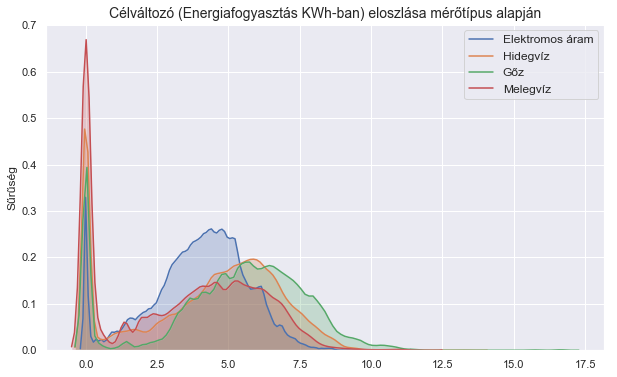

In [93]:
for meter_type in sorted(train['meter'].unique().tolist()):
    meter_reading = np.log1p(train[train.meter == meter_type]['meter_reading'])
    sns.kdeplot(meter_reading, shade=True)

plt.legend(['Elektromos áram', 'Hidegvíz', 'Gőz', 'Melegvíz'], prop={'size': 12})
plt.title('Célváltozó (Energiafogyasztás KWh-ban) eloszlása mérőtípus alapján',  fontsize=14)
plt.ylabel('Sűrűség')  

Az energiafogasztás (logaritmusának) eloszlása a különböző mérőtípusok szerinti bontásban rámutat arra, hogy nagy számban találhatunk zéró értéket az adatszettben, mely az elektromos áram esetében a legkevesebb, míg a melegvíz esetében a legtöbb. Az eloszlás némi eltérést mutat az egyes mérőtípusok esetében, főként az elektromos áram tekintetében, míg a hidegvíz és a gőz mőrő szerinti fogyasztás eloszlása meglehetősen hasonló. Összefoglalva, a mérőtípus változójának bevonása az elemzésbe indokolt az eltérő eloszlások láttán.

#### Az idő aspektus vizsgálata a célváltozó függvényében

In [94]:
train["timestamp"] = pd.to_datetime(train["timestamp"])
train["hour"] = train["timestamp"].dt.hour
train["day"] = train["timestamp"].dt.day
train["weekend"] = train["timestamp"].dt.weekday
train["month"] = train["timestamp"].dt.month

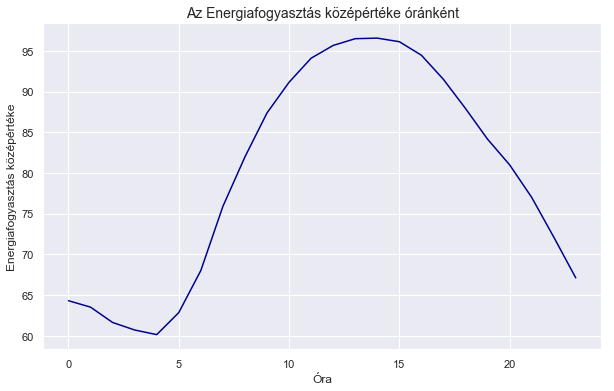

In [95]:
train['log_meter_reading'] = np.log1p(train['meter_reading'])
fig, ax = plt.subplots(figsize=(10,5))
train.groupby('hour')['meter_reading'].median().plot(kind='line', color="darkblue", figsize=(10,6), label=False)
ax.set_ylabel('Energiafogyasztás középértéke')
ax.set_xlabel('Óra')
plt.title("Az Energiafogyasztás középértéke óránként",  fontsize=14)
plt.show()

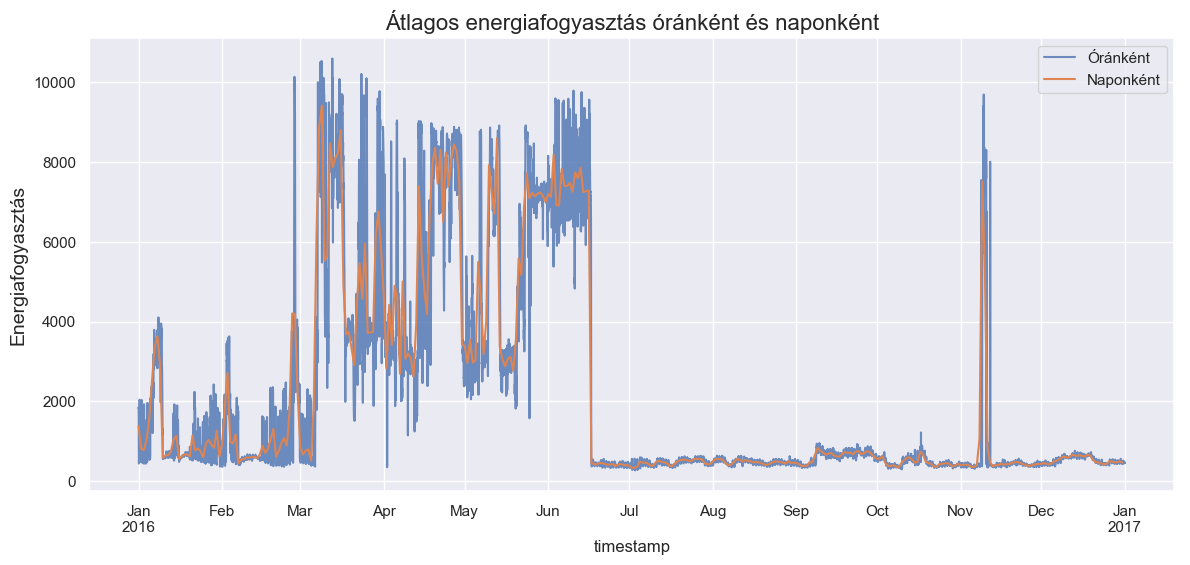

In [96]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6), dpi=100)
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, label='Óránként', alpha=0.8).set_ylabel('Energiafogyasztás', fontsize=14);
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes, label='Naponként', alpha=1).set_ylabel('Energiafogyasztás', fontsize=14);
axes.set_title('Átlagos energiafogyasztás óránként és naponként', fontsize=16);
axes.legend()

Az átlagos energiafogyasztás ábrája meglehetősen furán fest, március után jelentős ugrás látható, míg június közepétől szinte 0 közelébe esik.
Érdemes tehát egy közelebbi pillantást vetni rá.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001529911BF28>,
      dtype=object)

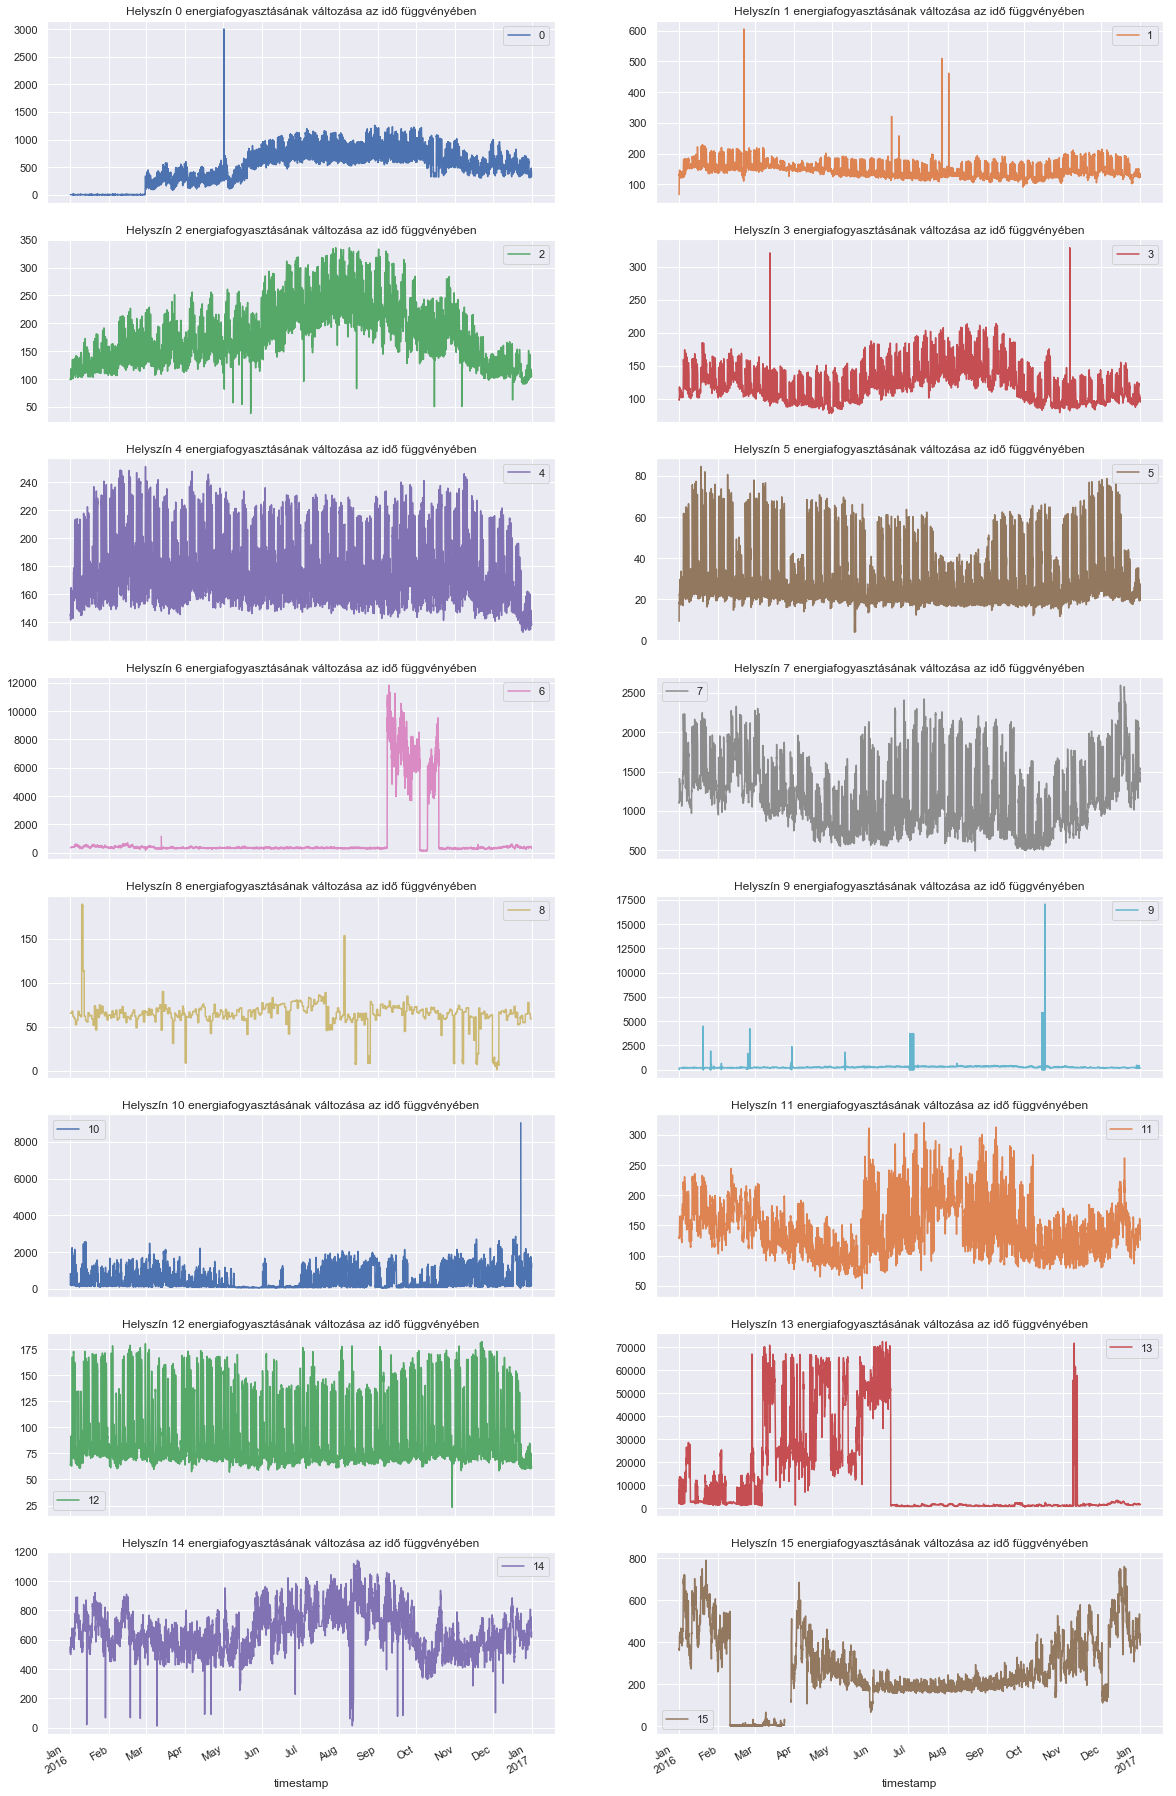

In [99]:
title_list = list()
for sites in range(train['site_id'].nunique()):
    title_list.append(str('Helyszín ' + str(sites) + str(' energiafogyasztásának változása az idő függvényében')))
    
train.groupby(['timestamp', 'site_id'])['meter_reading'].mean().unstack().plot(subplots=True, layout=(8,2), figsize=(20,35), title=title_list)

Egyrészről, az év eleji alacsony átlagos energiafogyasztásért részben az első helyszín (Site 0) április előtti adatainak hiánya okolható. Másrészről, a 13-as helyszín ábrája nagyrészt hasonlít a teljes minta ábrájához. Amennyiben visszaemlékszünk arra, hogy a legtöbb mérési adat ezen a helyszínen lévő épületekről áll rendelkezésre, illetve az átlagos energiafogyasztás jelentősen nagyobb ezen a helyszínen, akkor könnyen belátható jelentős hatása a teljes mintára. Érdemes tehát külön megvizsgálni, az egyes épülettípusoknak miképpen alakul ezen a területen az energiafogyasztása.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000152B1D10C18>,
      dtype=object)

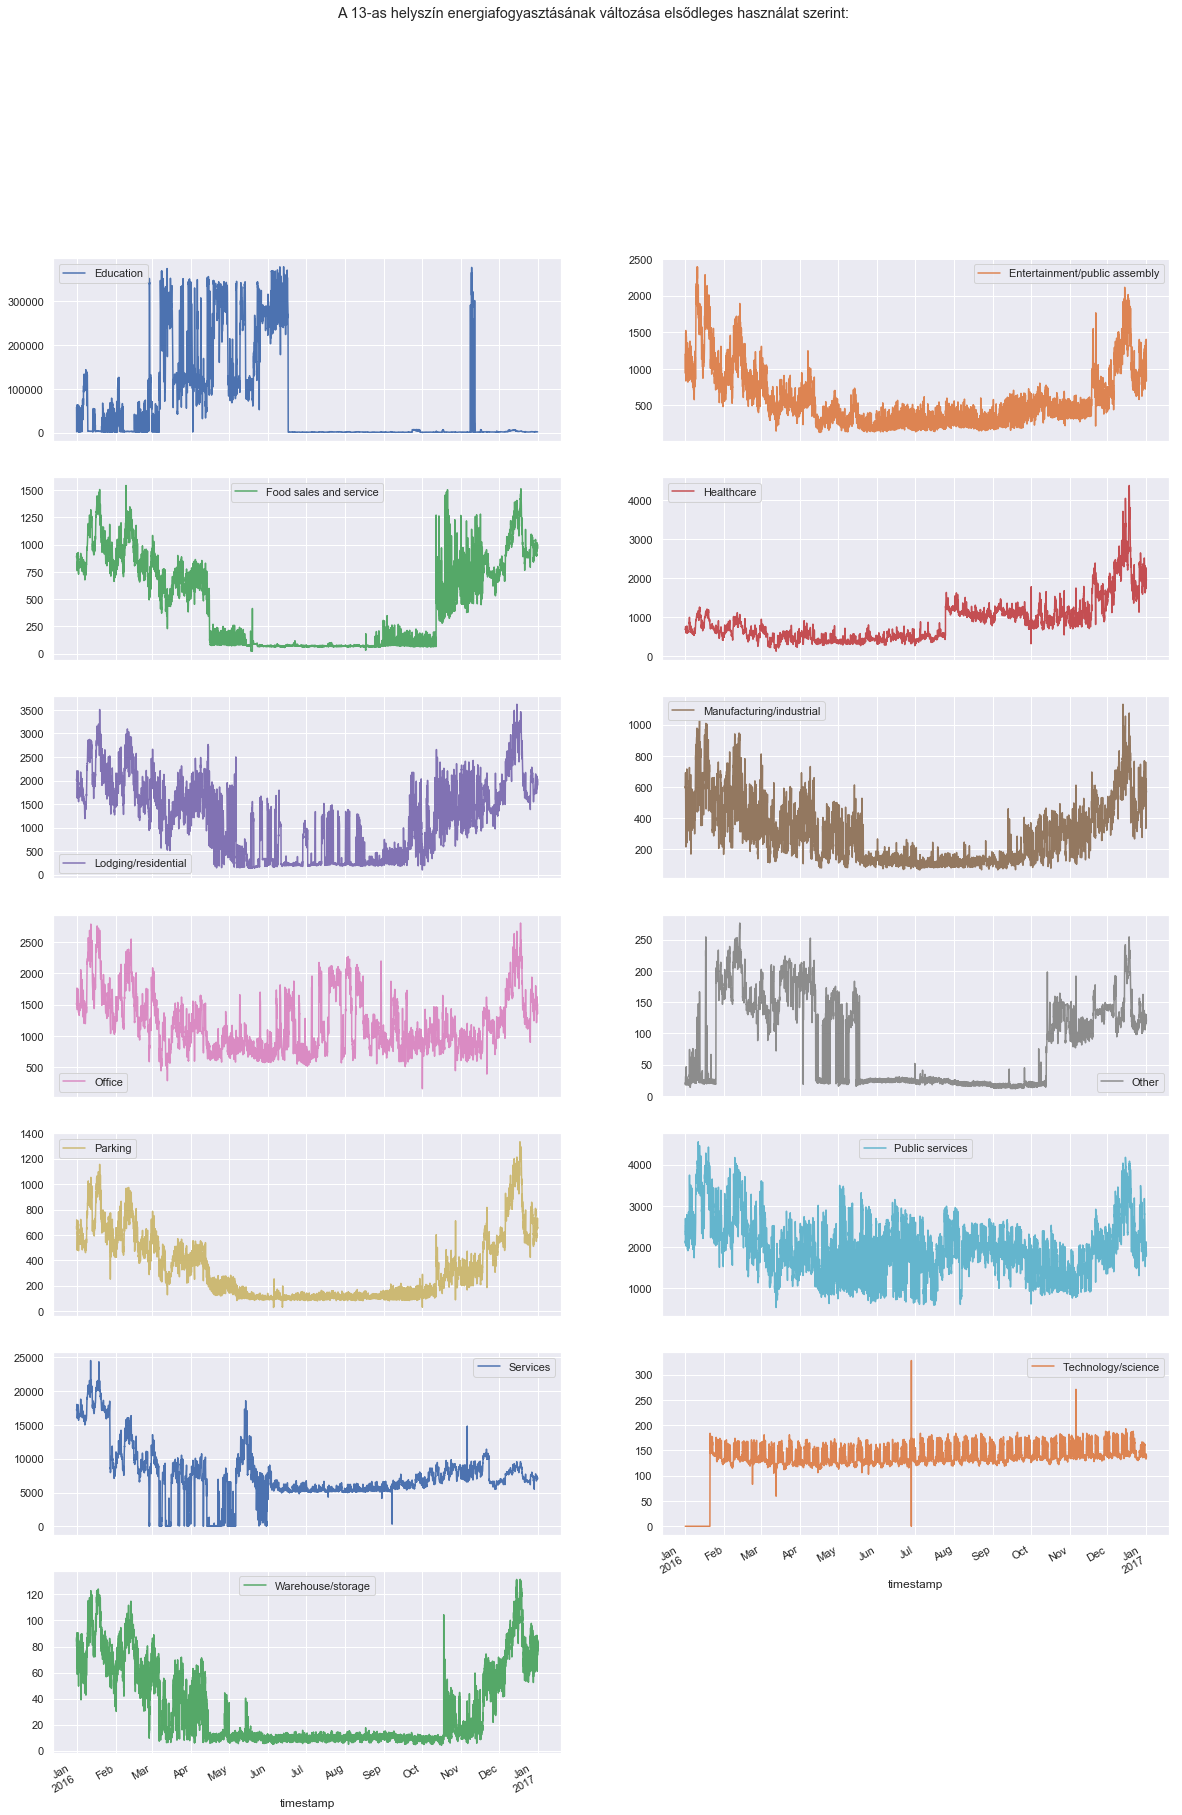

In [106]:
site_13_df = train[train.site_id == 13]
    
site_13_df.groupby(['timestamp', 'primary_use'])['meter_reading'].mean().unstack().plot(subplots=True, layout=(8,2), figsize=(20,35), title='A 13-as helyszín energiafogyasztásának változása elsődleges használat szerint:')

A fentiak alapján az oktatási intézmények között kell tovább kutatodni. Lássuk az ehhez a kategóriához tartozó épületeket.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000152AC44A358>,
      dtype=object)

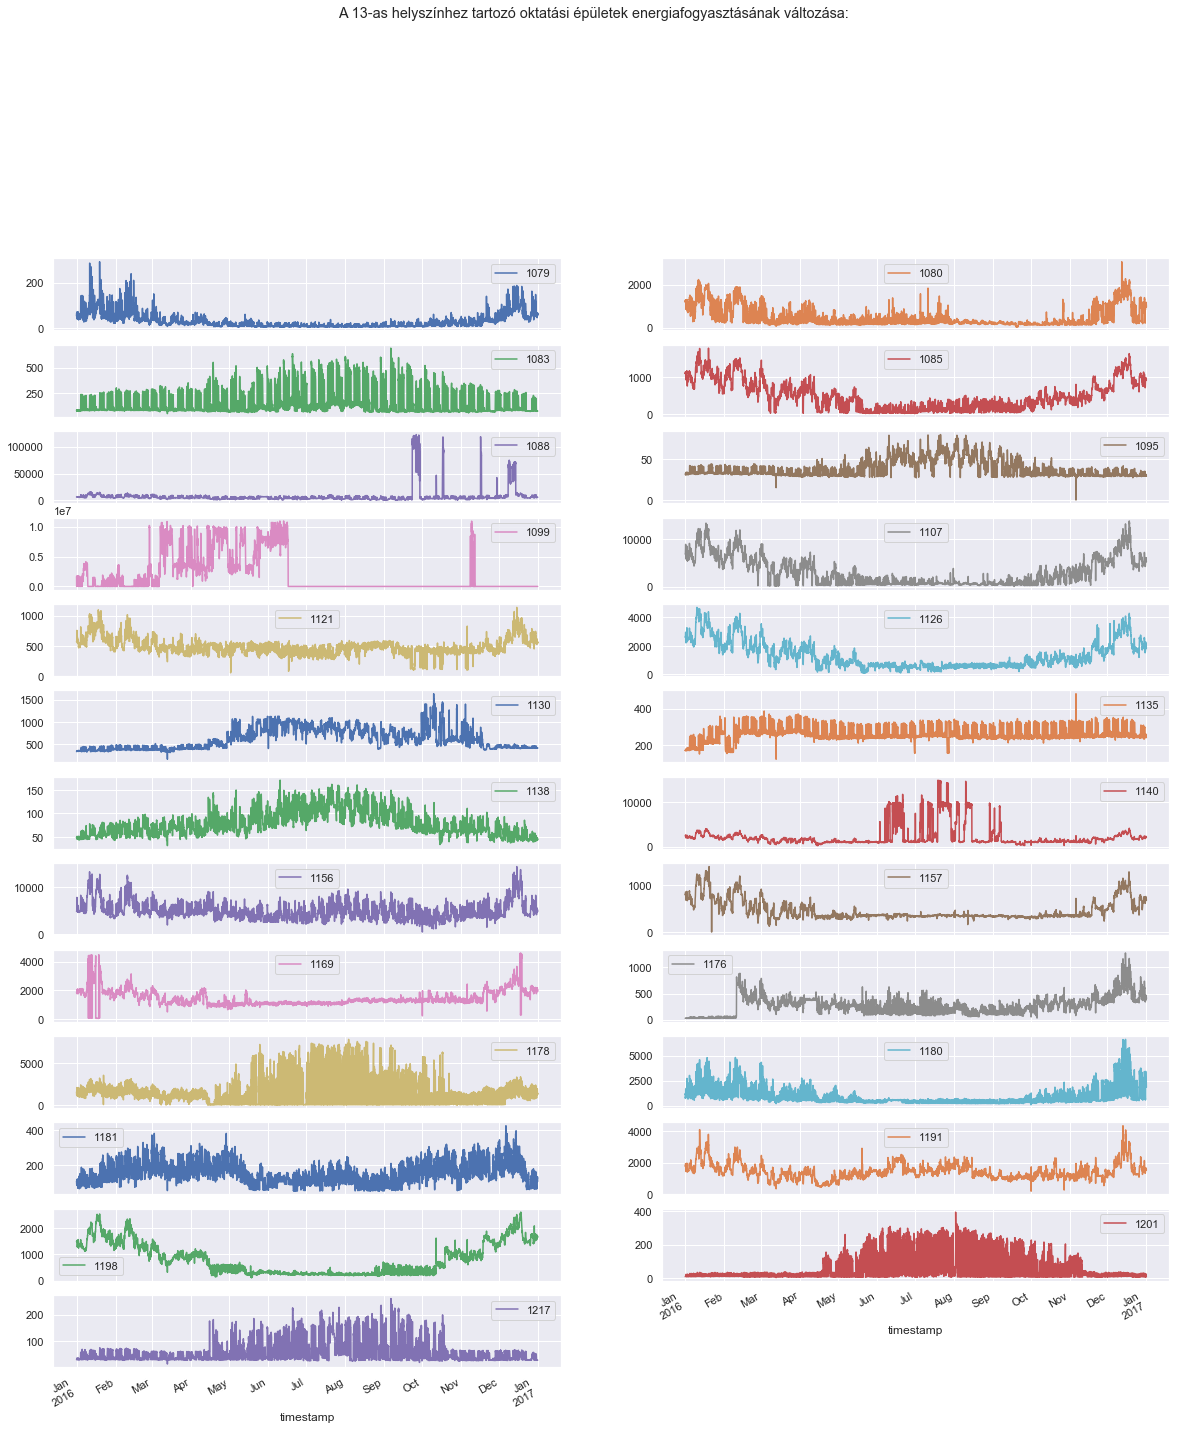

In [109]:
site_13_df = train[(train.site_id == 13) & (train.primary_use == 'Education')]
    
site_13_df.groupby(['timestamp', 'building_id'])['meter_reading'].mean().unstack().plot(subplots=True, layout=(20,2), figsize=(20,35), title='A 13-as helyszínhez tartozó oktatási épületek energiafogyasztásának változása:')

Az 1099-es számú épület egyfajta "általános átlagként" funkcionál, nélküle az adatok időbeni eloszlása jelentősen változik:

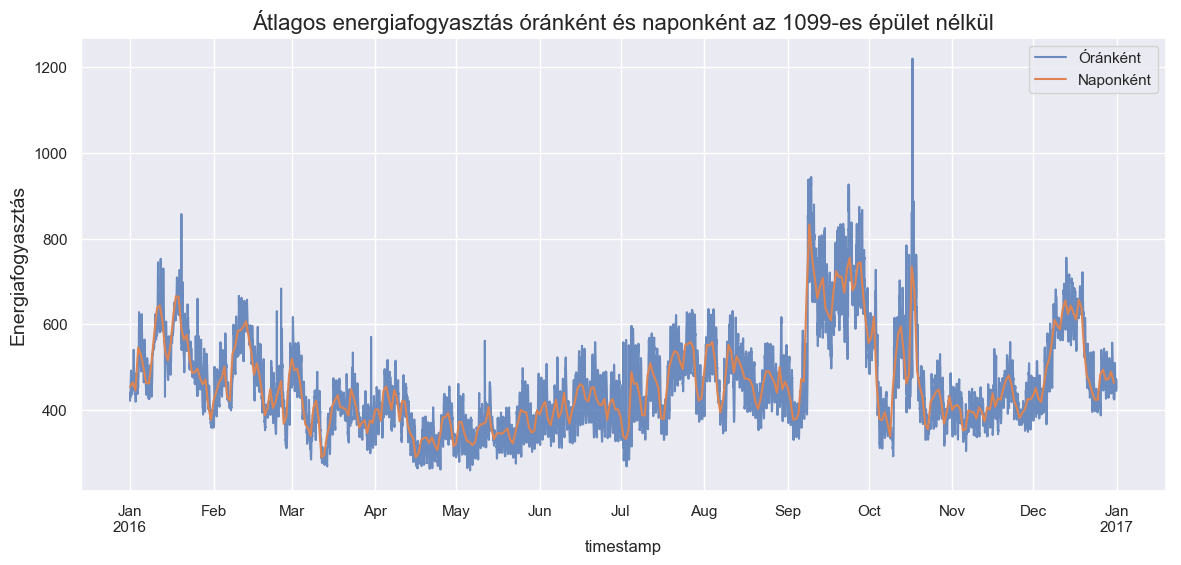

In [110]:
train_whtout_b1099 =  train[train.building_id != 1099]

fig, axes = plt.subplots(1, 1, figsize=(14, 6), dpi=100)
train_whtout_b1099[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, label='Óránként', alpha=0.8).set_ylabel('Energiafogyasztás', fontsize=14);
train_whtout_b1099[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes, label='Naponként', alpha=1).set_ylabel('Energiafogyasztás', fontsize=14);
axes.set_title('Átlagos energiafogyasztás óránként és naponként az 1099-es épület nélkül', fontsize=16);
axes.legend()

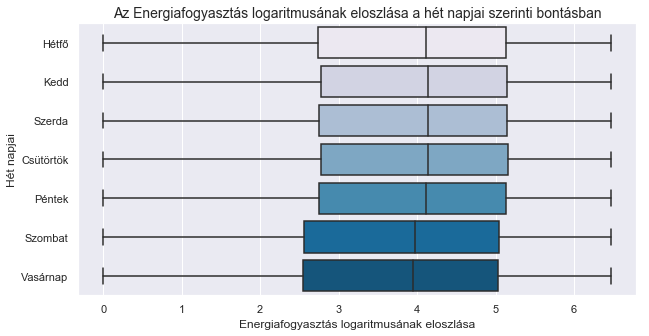

In [26]:
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.boxplot(y="weekend", x="log_meter_reading", data=train_no_outliers, orient="h", palette="PuBu")
ax.set_ylabel('Hét napjai')
ax.set_xlabel('Energiafogyasztás logaritmusának eloszlása')
ax.set_yticklabels(['Hétfő', 'Kedd', 'Szerda', 'Csütörtök', 'Péntek', 'Szombat', 'Vasárnap'])
plt.title('Az Energiafogyasztás logaritmusának eloszlása a hét napjai szerinti bontásban',  fontsize=14)
plt.show()

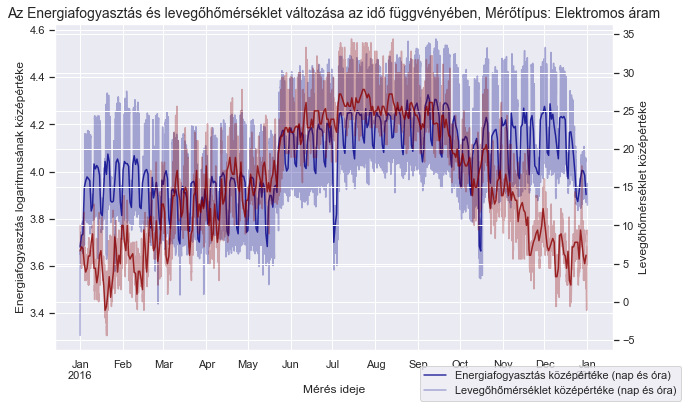

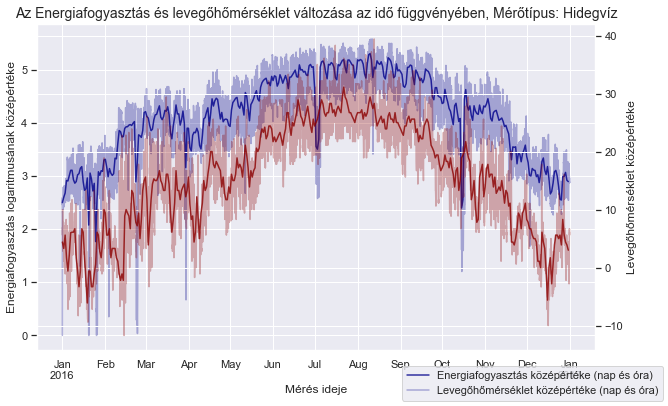

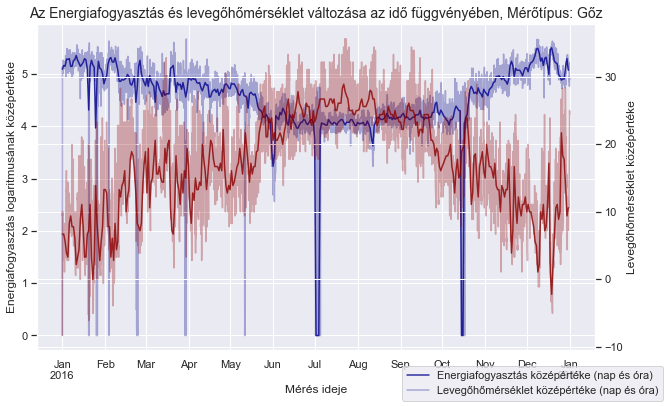

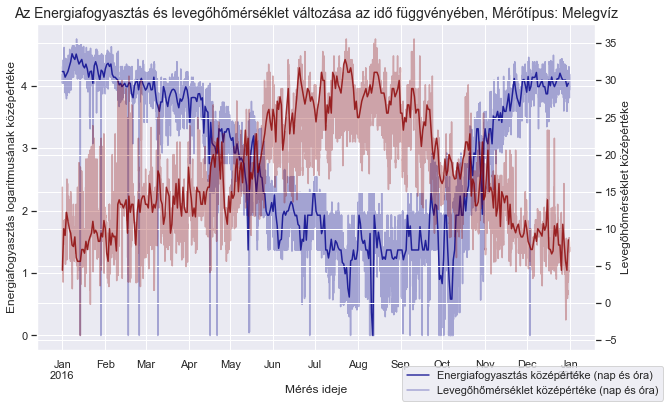

In [27]:
meter_types = ['Elektromos áram', 'Hidegvíz', 'Gőz', 'Melegvíz']
for meter_type in sorted(train_no_outliers['meter'].unique().tolist()):
    filtered_train = train_no_outliers[train_no_outliers.meter == meter_type]
    ax = filtered_train[['timestamp','log_meter_reading']].set_index('timestamp').resample("D")['log_meter_reading'].median().plot(kind='line', color="darkblue", figsize=(10,6), alpha=0.8, label=False)
    filtered_train[['timestamp','log_meter_reading']].set_index('timestamp').resample("H")['log_meter_reading'].median().plot(kind='line', color="darkblue", figsize=(10,6), alpha=0.3, label=False)
    ax2 = ax.twinx()
    filtered_train[['timestamp','air_temperature']].set_index('timestamp').resample("D")['air_temperature'].median().plot(ax=ax2, kind='line', color="darkred", figsize=(10,6), alpha=0.8, label=False)
    filtered_train[['timestamp','air_temperature']].set_index('timestamp').resample("H")['air_temperature'].median().plot(ax=ax2, kind='line', color="darkred", figsize=(10,6), alpha=0.3, label=False)
    ax.figure.legend(['Energiafogyasztás középértéke (nap és óra)', 'Levegőhőmérséklet középértéke (nap és óra)'], loc='lower right')
    ax.set_ylabel('Energiafogyasztás logaritmusának középértéke'); ax2.set_ylabel('Levegőhőmérséklet középértéke')
    ax.set_xlabel("Mérés ideje")
    plt.title("Az Energiafogyasztás és levegőhőmérséklet változása az idő függvényében, " + str('Mérőtípus: ') + str(meter_types[meter_type]),  fontsize=14)
    plt.show()

Text(0.5, 1.0, 'Az Energiafogyasztás és levegőhőmérséklet változása az idő függvényében')

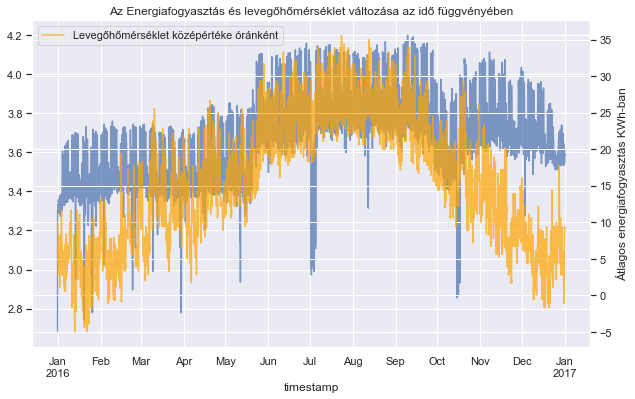

In [28]:
ax = train_no_outliers[['timestamp','log_meter_reading']].set_index('timestamp').resample("H")['log_meter_reading'].mean().plot(kind='line',figsize=(10,6), alpha=0.7, label='Összes energiafogyasztás óránként')
ax2 = ax.twinx()
train_no_outliers[['timestamp','air_temperature']].set_index('timestamp').resample("H")['air_temperature'].median().plot(ax=ax2, kind='line', color="orange", figsize=(10,6), alpha=0.7, label='Levegőhőmérséklet középértéke óránként')
plt.legend()
plt.xlabel("Mérés ideje")
plt.ylabel("Átlagos energiafogyasztás KWh-ban")
plt.title("Az Energiafogyasztás és levegőhőmérséklet változása az idő függvényében")

#### A használati típus szerinti energiafogyasztás vizsgálata

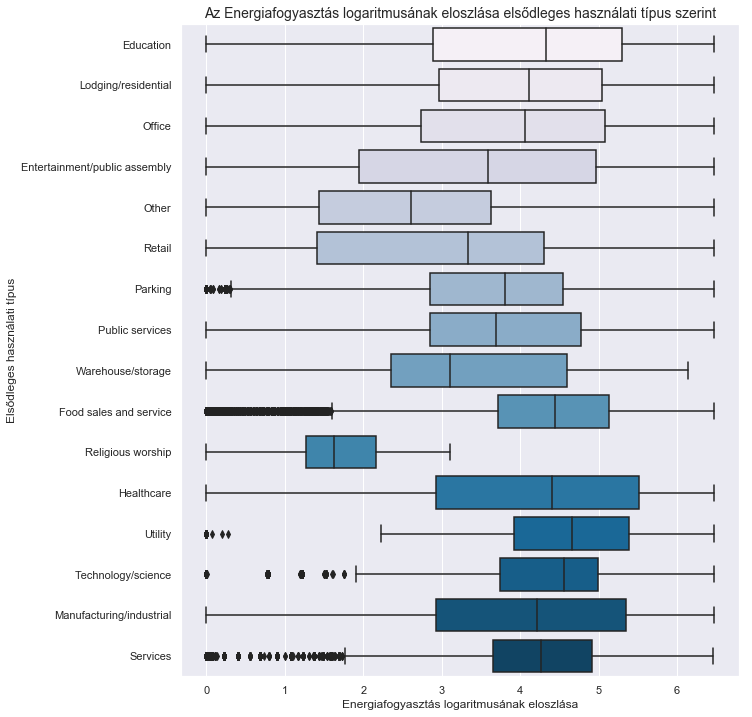

In [29]:
sorted(train_no_outliers['primary_use'].unique().tolist())
fig, ax = plt.subplots(figsize=(10,12))
ax = sns.boxplot(y="primary_use", x="log_meter_reading", data=train_no_outliers, orient="h", palette="PuBu")
ax.set_ylabel('Elsődleges használati típus')
ax.set_xlabel('Energiafogyasztás logaritmusának eloszlása')
plt.title('Az Energiafogyasztás logaritmusának eloszlása elsődleges használati típus szerint',  fontsize=14)
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001529B56FEF0>,
      dtype=object)

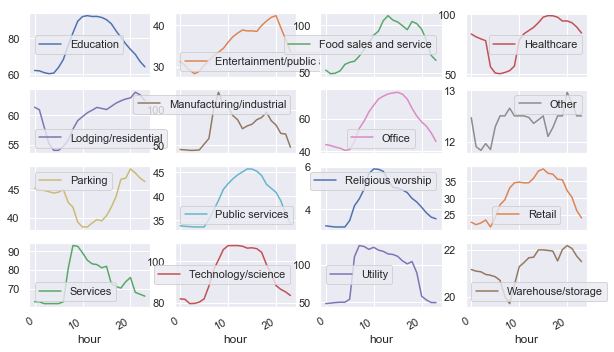

In [30]:
train_no_outliers.groupby(['hour', 'primary_use'])['meter_reading'].median().unstack().plot(subplots=True, layout=(4,4))

#### Energiafogyasztás vizsgálata telephely szerinti bontásban

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001528209D9E8>,
      dtype=object)

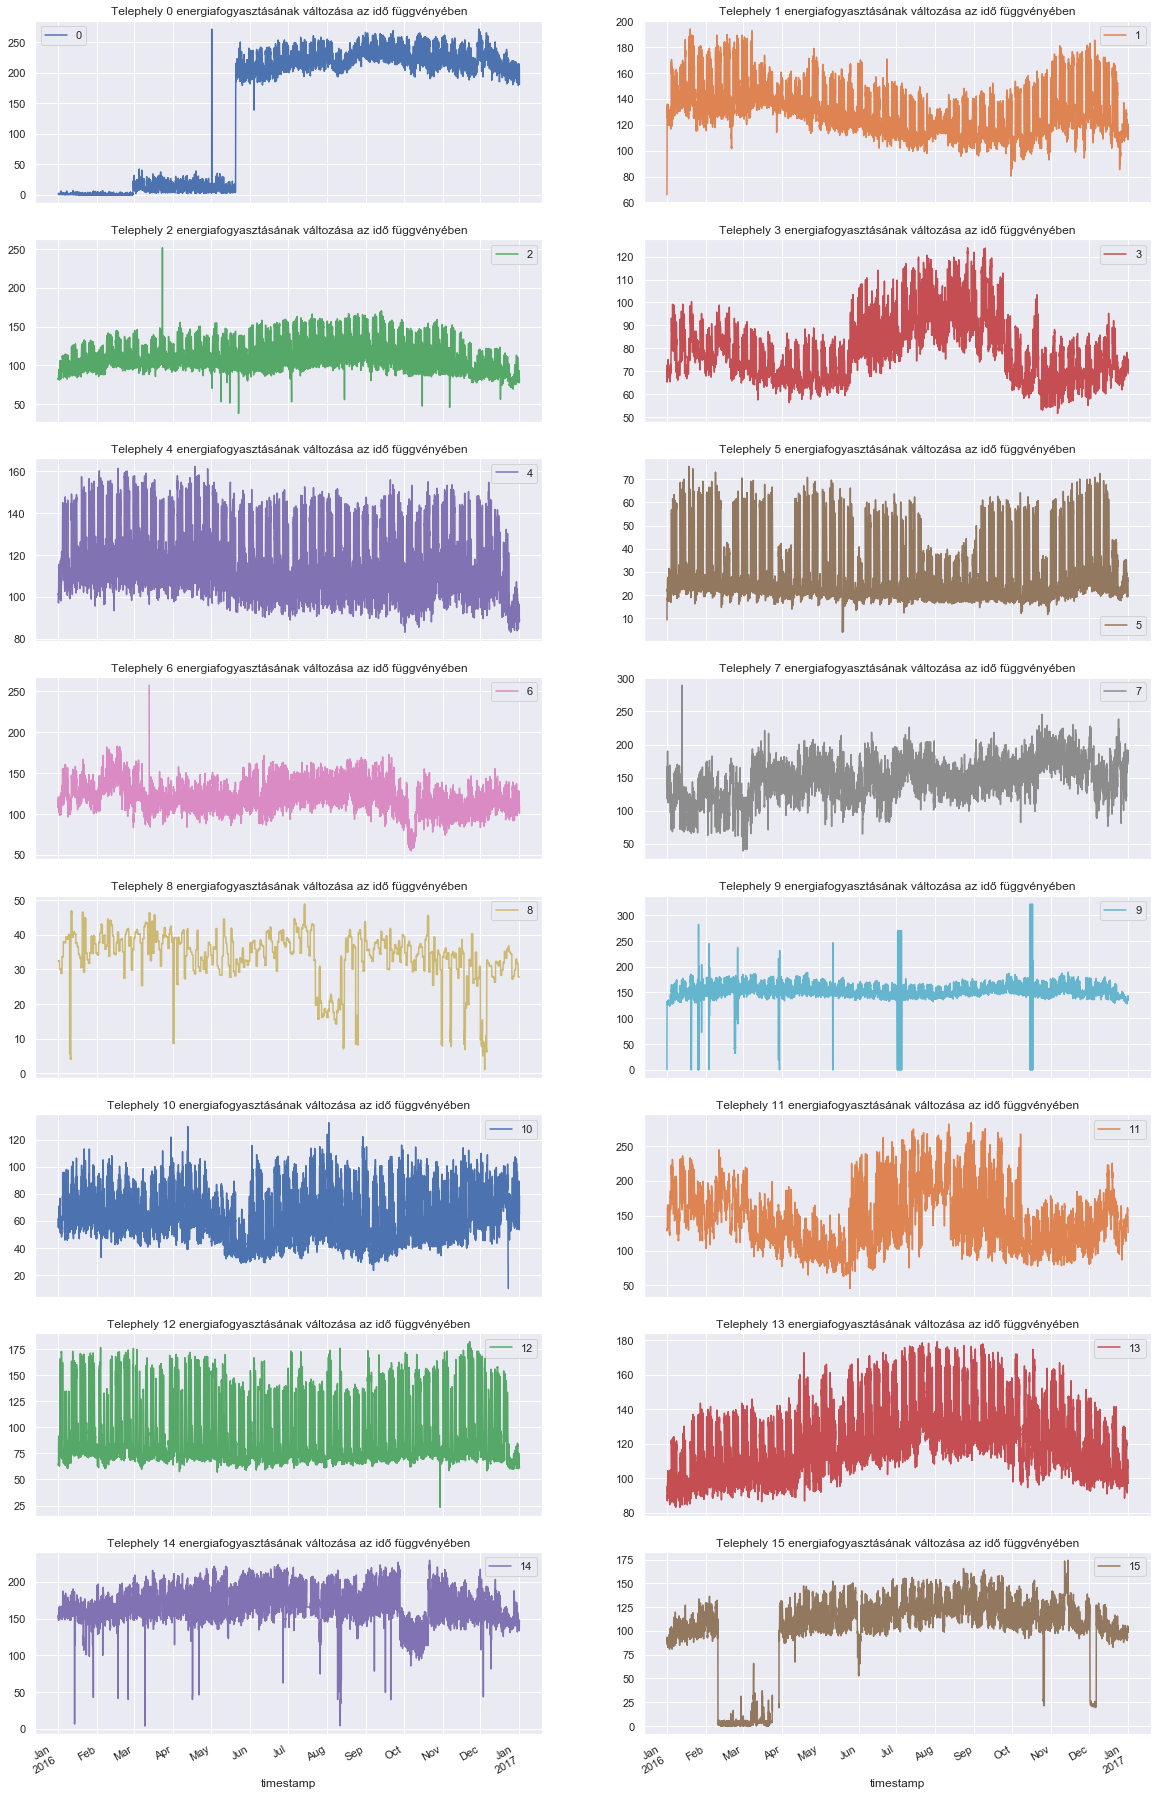

In [31]:
title_list = list()
for sites in range(train['site_id'].nunique()):
    title_list.append(str('Telephely ' + str(sites) + str(' energiafogyasztásának változása az idő függvényében')))
    
train_no_outliers.groupby(['timestamp', 'site_id'])['meter_reading'].mean().unstack().plot(subplots=True, layout=(8,2), figsize=(20,35), title=title_list)

#### Energiafogyasztás vizsgálata épületenként

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6), dpi=100)
train_no_outliers[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, label='Óránként', alpha=0.8).set_ylabel('Energiafogyasztás', fontsize=14);
train_no_outliers[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes, label='Naponként', alpha=1).set_ylabel('Energiafogyasztás', fontsize=14);
axes.set_title('Átlagos energiafogyasztás óránként és naponként', fontsize=16);
axes.legend()

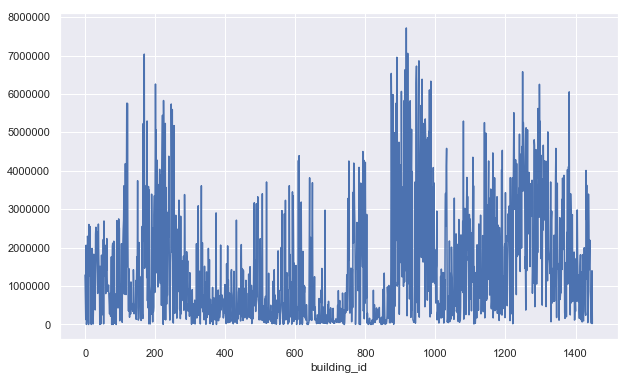

In [36]:
train_no_outliers.groupby(['building_id'])['meter_reading'].sum().plot()

### <span style="color:dimgray"> Változók alakítása </span>

#### Szélirány átalakítása kategórikus változóvá. Részleteket lásd a következő kernelben:
https://www.kaggle.com/caesarlupum/ashrae-ligthgbm-simple-fe

[0]
[0, 0]
[0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12

TypeError: cannot do label indexing on <class 'pandas.core.indexes.numeric.Int64Index'> with these indexers [nan] of <class 'float'>

In [52]:
train_no_outliers['wind_direction'].unique()

array([  0., 240., 270., 350.,  nan, 280., 200., 250.,  70., 230., 360.,
       260.,  20., 190., 300., 330.,  10.,  50., 170.,  90., 160.,  30.,
       340., 110., 310., 130., 290., 100., 120.,  60., 150., 210.,  80.,
        40., 320., 140., 220., 180., 174., 176.,  84., 198., 196., 202.])

In [59]:
train_no_outliers.loc[train_no_outliers[np.isnan(train_no_outliers['wind_direction']) == True]] 

ValueError: Cannot index with multidimensional key

In [47]:
print(train_no_outliers.columns)

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'hour', 'day', 'weekend', 'month', 'log_meter_reading'],
      dtype='object')


### <span style="color:dimgray"> Model illesztése </span>